In [2]:
cd /home/drew/NBOH

/scr/drew/Serotonin/6WHA/equilibration/tryIonicCapsInSolvent/di-S-bond_ECL3/6WGTTmplt4EXL3/Desmond/Hirshfeld/retry/blockMembraneBackdoor/retry


In [19]:
import subprocess as subp
import pandas as pd
import numpy as np
from collections import defaultdict 
import bioinf as bi
import os

ligand = "NAP"
ligand_part = "full"
includes = []#"336", "339", "340"]

ligands = {
    "CMYH": "25CN-NBOH",
    "NAP": "25N-N1-Nap (16)"
}

ligand_keys = list(ligands.keys())

paths = {
    ligand_keys[0]: "/home/drew/NBOH",
    ligand_keys[1]: "/home/drew/Nap"
}

assert(len(paths) == len(ligand_keys))

os.chdir(paths[ligand])

ligand_name = ligands[ligand]

ligand_part_names = {
    "full": ligand,
    "PEA": "Lig_PEARing",
    "NBenzyl": "Lig_NBenzylRing",
    "rest": "Lig_Neck"
}

part_keys = list(ligand_part_names.keys())

file_prefix = {
    part_keys[0]: ligand,
    part_keys[1]: "PEARing",
    part_keys[2]: "NBenzylRing",
    part_keys[3]: "Neck"
}

assert(len(part_keys) == len(file_prefix))

header_suffix = {
    part_keys[0]: "ligand",
    part_keys[1]: "PEA Ring",
    part_keys[2]: "N-Benzyl Ring",
    part_keys[3]: "Full"
}

assert(len(part_keys) == len(header_suffix))

In [20]:
subprocess = subp.run(["gmx", "dump", "-e", "pocketEnergy.edr"], capture_output=True, text=True)

In [22]:
interactor = ligand_part_names[ligand_part]
times = np.array([])
pocket_residues = defaultdict(lambda: np.array([]))
resB = ''
for line in subprocess.stdout.splitlines():
    stripped = line.strip()
    if stripped.startswith('time:'):
        time = float(stripped.split()[1])/1000.0
        times = np.append(times, time)
        continue
    if not stripped.startswith('Coul-SR:') and not stripped.startswith('LJ-SR:'):
        continue
    res_and_val = stripped.split(':')[1]
    residues, value = res_and_val.split()
    resA, temporary = residues.split('-')
    if resA != interactor or temporary in ligand_part_names.values():
        continue
    if temporary == "rest":
        continue
    energy_term = float(value)
    temporary = temporary[1:]
    if temporary == resB:
        pocket_residues[resB][-1] += energy_term
        continue
    resB = temporary
    a = pocket_residues[resB]
    a = np.append(a, np.array([energy_term]))
    pocket_residues[resB] = a

In [23]:
df = pd.DataFrame(pocket_residues, index=times)

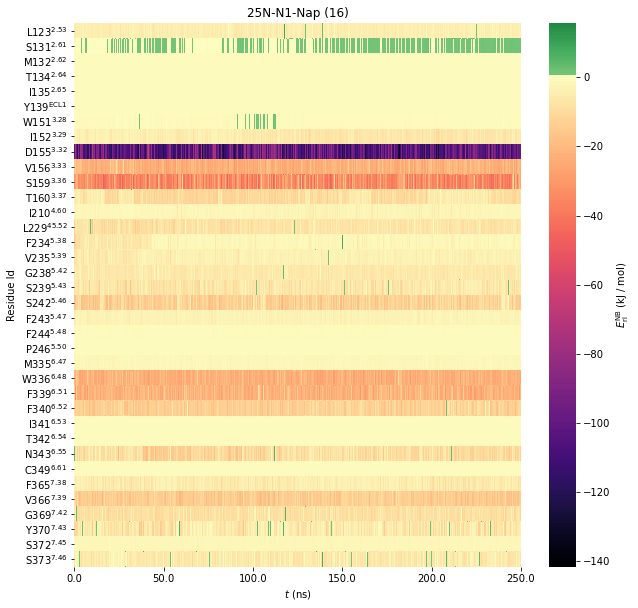

In [24]:
import seaborn as sn
import matplotlib.pyplot as plt
import math 
import matplotlib.colors as mcolors

to_plot = df[includes] if len(includes) else df

def toBW(a):
    receptor = bi.Receptor("5ht2a_human")
    residue = receptor.residue_for_index(a)
    if not residue:
        return 'rest'
    return f'{residue.lett_seq_num}$^{{\mathregular{{{residue.bw if residue.bw else residue.protein_segment}}}}}$'
    
BW_columns = to_plot.columns 
vfunc = np.vectorize(toBW)

plot = plt.figure(figsize=(10, 10))
ax = plt.axes()

n_colors = 256
neg_range = math.ceil(abs(to_plot.to_numpy().min())/np.ptp((to_plot)) * n_colors + 0.5)
colors1 = plt.cm.magma(np.linspace(0., 1, neg_range))
colors2 = plt.cm.Greens(np.linspace(.5, .75, n_colors - neg_range))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

# cmap = plt.get_cmap('magma')
# cmap.set_over('green')
sn.heatmap(to_plot.T, robust=False, cbar_kws={'label': r'$E^{\mathregular{NB}}_{\mathregular{rl}}$ (kJ / mol)'}, 
           xticklabels=5000, yticklabels=vfunc(BW_columns), cmap=cmap, ax=ax)#, vmin=-50)
ax.set_xlabel(r'$t$ (ns)')
ax.set_ylabel("Residue Id")
suffix = "" if ligand_part == "full" else f" {header_suffix[ligand_part]}"
ax.set_title(f'{ligands[ligand]}{suffix}')#25N-N1-Nap (16)')#Methiothepin')#
plt.yticks(rotation=0)
interactee = "HelixVI" if len(includes) > 3 else "Pocket"
plt.savefig(f'{file_prefix[ligand_part]}-{interactee}EnergyInteractionTimeSeriesHeatmap.png', dpi=300) #TODO: make "HelixVI" or "Pocket" depend on len of includes

In [67]:
df

,123,131,132,134,135,139,151,152,155,156,...,342,343,349,365,366,369,370,372,373,est
0.00,-0.149277,0.023813,-0.000129,0.002310,-0.000154,-0.004194,-0.247392,-1.444688,-3.651287,-12.89262,...,-0.050351,-10.390380,-0.000212,-0.040684,-0.493278,-0.058305,-0.242699,-0.010006,-0.008703,-72.46710
0.01,-0.298646,-0.014543,0.000000,0.000748,-0.000050,-0.000885,-0.155690,-1.298184,-3.959915,-17.95495,...,-0.064823,-11.846130,-0.000294,-0.036599,-0.270576,-0.033704,-0.229699,-0.002466,-0.017236,-49.29720
0.02,-0.265306,-0.013415,0.000000,-0.001847,-0.001738,-0.000421,-0.136542,-2.451934,-1.499220,-11.29970,...,-0.166628,-29.395200,-0.000386,-0.068605,-0.555339,-0.059009,-0.338170,-0.004526,-0.025840,-41.27650
0.03,-0.224160,0.000275,0.000000,0.001675,-0.000139,0.000074,-0.155291,-1.023755,-3.492919,-14.32323,...,-0.148045,-35.090520,-0.000330,-0.087761,-0.522435,-0.068343,-0.317665,-0.005374,-0.020314,-30.08930
0.04,-0.201621,0.001324,0.000000,0.001495,0.000000,0.000048,-0.147282,-1.797328,-3.055380,-16.44818,...,-0.181486,-38.483120,-0.001112,-0.080022,-0.608967,-0.098214,-0.547580,-0.017950,-0.054013,-23.49268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249.96,-0.086566,-0.008002,-0.000681,-0.009979,-0.081980,0.000000,-0.140417,-1.204927,-4.404800,-20.67332,...,-0.055226,-2.546084,0.000000,-0.073833,-0.354030,-0.059347,-0.295521,-0.009754,-0.017147,-66.31690
249.97,-0.114128,-0.011326,-0.000760,-0.000833,-0.070647,0.000000,-0.240816,-1.045166,-4.246600,-13.61222,...,-0.077903,0.119640,0.000000,-0.067925,-0.414424,-0.088281,-0.376583,-0.020119,-0.016267,-73.59220
249.98,-0.115416,-0.012679,-0.001157,-0.001098,-0.053174,0.000000,-0.204243,-0.913140,-5.136950,-14.33420,...,-0.088754,-4.248370,0.000000,-0.064492,-0.528852,-0.087542,-0.391208,-0.011351,-0.014927,-58.62260
249.99,-0.135827,-0.022561,-0.000655,-0.011127,-0.094695,0.000000,-0.199883,-1.002110,-3.551660,-15.92568,...,-0.105452,-3.461730,0.000000,-0.068052,-0.440638,-0.078605,-0.248320,-0.010094,-0.013388,-49.47380


In [17]:
df.to_csv('fullLigand-PocketInteractionPMETimeSeries.dat', sep=' ')

In [12]:
interactor

'CMYH'